<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/03_case_study_intent_detection_with_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Case Study: Intent Detection with ONNX optimization

Let’s suppose that we’re trying to build a text-based assistant for our company’s call center so
that customers can request the balance of their account or make bookings without needing to
speak with a human agent. In order to understand the goals of a customer, our assistant will
need to be able to classify a wide variety of natural language text into a set of predefined
actions or intents.

For example, a customer may send a message about an upcoming trip:

```txt
Hey, I’d like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van
```

and our intent classifier could automatically categorize this as a Car Rental intent, which then triggers an action and response.

To be robust in a production environment, our classifier will
also need to be able to handle out-of-scope queries.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/images/1.png?raw=1' width='600'/>

In the third case, the text-assistant
has been trained to detect out-of-scope queries (usually labelled as a separate class) and informs the customer about which topics they can respond to.

As a baseline we’ve fine-tuned a BERT-base model that achieves around `94%` accuracy on the
`CLINC150` dataset. This dataset includes `22,500` in-scope queries across `150` intents and `10`
domains like banking and travel, and also includes `1,200` out-of-scope queries that belong to an
oos intent class. In practice we would also gather our own in-house dataset, but using public
data is a great way to iterate quickly and generate preliminary results.



##Setup

In [8]:
!pip -q install transformers[sentencepiece]
!pip -q install transformers[onnx]
!pip -q install datasets
!pip -q install optuna

In [9]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline)
from transformers import TrainingArguments, Trainer
from transformers import AutoConfig
from datasets import load_dataset, load_metric

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.quantized import QFunctional
from torch import quantize_per_tensor
from torch.quantization import quantize_dynamic


import optuna

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,mark_inset

# ONNX imports
from psutil import cpu_count
from transformers.convert_graph_to_onnx import convert
from onnxruntime import (GraphOptimizationLevel, InferenceSession, SessionOptions)
from onnxruntime_tools.transformers.onnx_model_bert import (BertOptimizationOptions)
from onnxruntime_tools import optimizer
from onnxruntime.quantization import quantize_dynamic, QuantType
from scipy.special import softmax

from pathlib import Path
from time import perf_counter

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
def plot_metrics(perf_metrics, current_optim_type):
  df = pd.DataFrame.from_dict(perf_metrics, orient="index")
  for idx in df.index:
    df_opt = df.loc[idx]
    if idx == current_optim_type:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, alpha=0.5, s=df_opt["size_mb"], label=idx, marker="$\u25CC$")
    else:
      plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100, s=df_opt["size_mb"], label=idx, alpha=0.5)
  legend = plt.legend(bbox_to_anchor=(1, 1))
  for handle in legend.legendHandles:
    handle.set_sizes([20])
  plt.ylim(80,90)
  plt.xlim(5, 53)
  plt.ylabel("Accuracy (%)")
  plt.xlabel("Average latency (ms)")
  plt.show()

Now, let’s download our fine-tuned model from the Hugging Face Hub and wrap it in a pipeline for text classification:

In [11]:
# molde path has changed: https://huggingface.co/transformersbook/bert-base-uncased-finetuned-clinc
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)
bert_model = (AutoModelForSequenceClassification.from_pretrained(bert_ckpt).to("cpu"))

bert_pipeline = TextClassificationPipeline(model=bert_model, tokenizer=bert_tokenizer)

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Here we’ve set the model’s device to cpu since our text-assistant will need to operate in an
environment where queries are processed and responded to in real-time.

Now that we have a pipeline, we can pass a query to get the predicted intent and confidence
score from the model:

In [12]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""

bert_pipeline(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

Great, the `car_rental` intent makes sense so let’s now look at creating a benchmark that we
can use to evaluate the performance of our baseline model.

##Performance Benchmark

Like any other machine learning model, deploying Transformers in production environments involves a trade-off among several constraints, the most common being:

- **Model performance**
  - How well does our model perform on a well-crafted test set that reflects production data?
- **Latency**
  - How fast can our model deliver predictions?
- **Memory**
  - How can we deploy billion-parameter models like GPT-2 or T5 that require gigabytes of disk storage and RAM?

Failing to address these constraints can have a negative impact on the user experience of your
application, or more commonly, lead to ballooning costs from running expensive cloud servers
that may only need to handle a few requests.

To explore how each of the these constraints can
be optimized with various compression techniques, let’s begin by creating a simple benchmark
that measures each quantity for a given pipeline and test set.

In [13]:
class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline") -> None:
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
    preds, labels = [], []
    for example in self.dataset:
      pred = self.pipeline(example["text"])[0]["label"]
      label = example["intent"]
      preds.append(intents.str2int(pred))
      labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy

  def compute_size(self):
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

  def time_pipeline(self, query="What is the pin number for my account?"):
    latencies = []
    # Warmup
    for _ in range(10):
      _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
      start_time = perf_counter()
      _ = bert_pipeline(query)
      latency = perf_counter() - start_time
      latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

  # We’ll use the run_benchmark function to collect all the metrics in a dictionary, with keys given by optim_type.
  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

First we need some data to test on, so let’s download the CLINC150 dataset that was used to finetune our baseline model. 

We can get the dataset from the Hub with the Datasets library as follows:

In [ ]:
clinc = load_dataset("clinc_oos", "plus")

In [15]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

Each example in the CLINC150 dataset consists of a query in the text column and its corresponding intent. 

We’ll use the test set to benchmark our models, so let’s take a look at one
of the dataset’s examples:

In [16]:
clinc["test"][42]

{'intent': 133, 'text': 'transfer $100 from my checking to saving account'}

The intents are provided as IDs, but we can easily get the mapping to strings (and vice versa)
by accessing the `Dataset.features` attribute:

In [17]:
intents = clinc["test"].features["intent"]
intents.int2str(clinc["test"][42]["intent"])

'transfer'

###Exploring Class distribution

Now that we have a basic understanding of the contents in the CLINC150 dataset, let’s check it class distribution.

In [18]:
clinc.set_format(type="pandas")

df = clinc["train"][:]
df.head()

,text,intent
0,what expression would i use to say i love you ...,61
1,can you tell me how to say 'i do not speak muc...,61
2,"what is the equivalent of, 'life is good' in f...",61
3,"tell me how to say, 'it is a beautiful morning...",61
4,"if i were mongolian, how would i say that i am...",61


In [19]:
def label_int2str(row, split):
  return clinc[split].features["intent"].int2str(row)

In [20]:
df["label_name"] = df["intent"].apply(label_int2str, split="train")
df.head()

,text,intent,label_name
0,what expression would i use to say i love you ...,61,translate
1,can you tell me how to say 'i do not speak muc...,61,translate
2,"what is the equivalent of, 'life is good' in f...",61,translate
3,"tell me how to say, 'it is a beautiful morning...",61,translate
4,"if i were mongolian, how would i say that i am...",61,translate


In [21]:
df["label_name"].value_counts(ascending=True)

bill_balance       100
meaning_of_life    100
oil_change_when    100
definition         100
book_flight        100
                  ... 
interest_rate      100
bill_due           100
book_hotel         100
calendar           100
oos                250
Name: label_name, Length: 151, dtype: int64

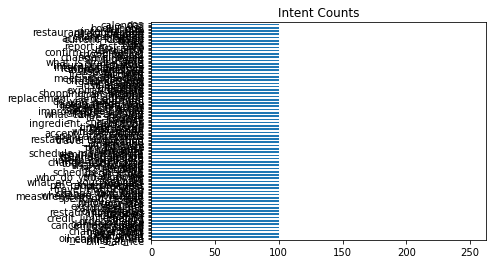

In [22]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Intent Counts");

In [23]:
# reset back to original format
clinc.reset_format()

###Benchmark statistics

Since the dataset is balanced across the intent
classes, we’ll use accuracy as our metric which we can load from Datasets.

let’s implement the compute_accuracy function:

In [24]:
accuracy_score = load_metric("accuracy")
accuracy_score

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

The metric’s description tells us that we need to provide the predictions and references (i.e. the ground truth labels) as integers, so we can use the pipeline to extract the predictions from the
text field and then use the `ClassLabel.str2int` function to map the prediction to its corresponding ID.

So we need to collect all the predictions and labels in lists before
returning the accuracy on the dataset. 

Next, let’s compute the size of our model by using the `torch.save` function from PyTorch to serialize the model to disk.In PyTorch,
the recommended way to save a model is by using its `state_dict`, which is a Python dictionary that maps each layer in a model to its learnable parameters (i.e. weights and biases).

Let’s see what is stored in the `state_dict` of our baseline model:

In [25]:
list(bert_pipeline.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

We can clearly see that each key-value pair corresponds to a specific layer and tensor in BERT.

We can then use the Path.stat function from Python’s `pathlib` module to get information about the underlying files. In particular `Path(PATH).stat().st_size` will give us the model size in bytes.

Finally let’s implement the `time_pipeline` function so that we can time the median latency
per query. For this application, latency refers to the time it takes to feed a text query to the
pipeline and return the predicted intent from the model.

Under the hood, the pipeline also
tokenizes the text but this is around 1,000 times faster than generating the predictions and thus
adds a negligible contribution to the overall latency.

A simple way to measure the time of a
code snippet is to use the `perf_counter` function from Python’s `time` module. This function has a better time resolution than the `time.time` function and so is well suited for getting precise results.

We can use `perf_counter` to time our `pipeline` by passing our test query and calculating the
time difference in milliseconds between the start and end:

In [26]:
for _ in range(3):
  start_time = perf_counter()
  _ = bert_pipeline(query)
  latency = perf_counter() - start_time
  print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 125.983
Latency (ms) - 117.675
Latency (ms) - 124.652


So instead,
we’ll collect the latencies over many runs and then use the resulting distribution to calculate the
mean and standard deviation, which will give us an idea about the spread in values. 

###Benchmarking Our Baseline Model

Now that our `PerformanceBenchmark` is complete, let’s give it a spin! For the baseline
model we just need to pass the pipeline and dataset we wish to perform the benchmark on, and
we’ll collect the results in the `perf_metrics` dictionary to keep track of each model’s
performance:

In [27]:
pb = PerformanceBenchmark(bert_pipeline, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 76.69 +\- 3.85
Accuracy on test set - 0.867


Once we have determined the best performing model we can then explore different backends to reduce the absolute latency if needed.

Now that we have a reference point, let’s look at our first compression technique: **knowledge distillation**.

##Knowledge Distillation for Smaller Models 

Knowledge distillation is a general-purpose method for training a smaller student model to mimic the behavior of a slower, larger, but better performing teacher.

###Knowledge Distillation for Pretraining

Knowledge distillation can also be used during pretraining to create a general-purpose student
that can be subsequently fine-tuned on downstream tasks. In this case, the teacher is a
pretrained language model like BERT which transfers its knowledge about masked-languagemodeling
to the student. 

For example, in the DistilBERT paper, the masked-languagemodeling
loss $L_{mlm}$ is augmented with a term from knowledge distillation and a cosine
embedding loss $L_{cos} = 1− cos (h_s, h_t)$ to align the directions of the hidden state vectors between the teacher and student:

$$L_{DistilBERT} = \alpha L_{mlm} + \beta L_{KD} + \gamma L_{cos}$$

Since we already have a fine-tuned BERT-base model, let’s see how we can use knowledge distillation to fine-tune a smaller and faster model. To do that we’ll need a way to augment the cross-entropy loss with a $L_{KD}$ term; fortunately we can do this by creating our own trainer!

####Knowledge Distillation Trainer

To implement knowledge distillation we need to add a few things to the `Trainer` base class:

- The new hyperparameters $\alpha$ and $T$ which control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed.
- The fine-tuned teacher model, which in our case is `BERT-base`
- A new loss function that includes the cross-entropy loss with the knowledge
distillation loss.

Adding the new hyperparameters is quite simple since we just need to subclass
`TrainingArguments` and include them as new attributes:

In [28]:
class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

For the trainer itself, we want a new loss function so the way to implement this is by subclassing `Trainer` and overriding the `compute_loss` function to include the knowledge distillation loss term $L_{KD}$:

In [29]:
class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  #reference: https://discuss.huggingface.co/t/custom-loss-compute-loss-got-an-unexpected-keyword-argument-return-outputs/4148
  def compute_loss(self, model, inputs, return_outputs=False):
    outputs_student = model(**inputs)
    # Extract cross-entropy loss and logits from student
    loss_ce = outputs_student.loss
    logits_student = outputs_student.logits
    # Extract logits from teacher
    with torch.no_grad():
      outputs_teacher = self.teacher_model(**inputs)
      logits_teacher = outputs_teacher.logits
    # Soften probabilities and compute distillation loss
    loss_kld = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_kld(
        F.log_softmax(logits_student / self.args.temperature, dim=-1),
        F.softmax(logits_teacher / self.args.temperature, dim=-1)
    )
    # Return weighted student loss
    return (loss_ce, outputs_student) if return_outputs else  self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd

In [30]:
help(Trainer.compute_loss)

Help on function compute_loss in module transformers.trainer:

compute_loss(self, model, inputs, return_outputs=False)
    How the loss is computed by Trainer. By default, all models return the loss in the first element.
    
    Subclass and override for custom behavior.



When we instantiate `DistillationTrainer`, we pass a `teacher_model` argument with a teacher that has already been fine-tuned on our task. 

Next, in the `compute_loss` function we extract the logits from the student and teacher, scale them
by the temperature and then normalize them with a softmax before passing them to PyTorch’s `nn.KLDivLoss` function for computing the KL divergence. 
Since `nn.KLDivLoss` expects the inputs in the form of `log-probabilities`, we’ve used the `F.log_softmax` function to
normalize the student’s logits, while the teacher’s logits are converted to probabilities with a standard softmax. The `reduction=batchmean` argument in `nn.KLDivLoss` specifies that we average the losses over the batch dimension.

####Student Initialization

We should pick smaller model for the student to reduce the latency and memory footprint, and a good rule of thumb from the literature is that knowledge distillation works best when the teacher and student are of the same model type.

One possible reason for this is that different model types, say BERT and
RoBERTa, can have different output embedding spaces which hinders the ability of the student to mimic the teacher.

In our case study, the teacher is BERT-base so DistilBERT is natural
candidate to intitialize the student since it has 40% less parameters and has been shown to achieve strong results on downstream tasks.

First we’ll need to tokenize and encode our queries, so let’s instantiate the tokenizer from DistilBERT and create a simple function to take care of the preprocessing:

In [31]:
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [32]:
def tokenize_text(batch, tokenizer):
  return tokenizer(batch["text"], truncation=True)

In [33]:
# removed the text column since we no longer need it
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"], fn_kwargs={"tokenizer": student_tokenizer})
# renamed the intent column to labels so it can be automatically detected by the trainer
clinc_enc.rename_column_("intent", "labels")

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

rename_column_ is deprecated and will be removed in the next major version of datasets. Use DatasetDict.rename_column instead.



In [34]:
clinc_enc["train"][0]

{'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'input_ids': [101,
  2054,
  3670,
  2052,
  1045,
  2224,
  2000,
  2360,
  1045,
  2293,
  2017,
  2065,
  1045,
  2020,
  2019,
  3059,
  102],
 'labels': 61}

Now that our texts are processed, the next thing to do is instantiate
DistilBERT for fine-tuning. Since we will be doing multiple runs with the trainer, we’ll use a function to initialize the model with each new run:

In [35]:
num_labels = intents.num_classes
id2label = bert_model.config.id2label
label2id = bert_model.config.label2id

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels, id2label=id2label, label2id=label2id))

In [37]:
def student_init():
  return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

Next, we need to define the metrics to track during training. As we did in the
performance benchmark, we’ll use accuracy as the main metric so we can reuse our
`accuracy_score` function in the `compute_metrics` function that we’ll include in the trainer:

In [38]:
def compute_metrics(pred):
  predictions, labels = pred
  # find the most confident class prediction
  predictions = np.argmax(predictions, axis=1)
  # and compare that against the ground truth labels
  return accuracy_score.compute(predictions=predictions, references=labels)

Finally, we just need to define the training arguments. To warm-up, we’ll set $\alpha = 1$ to see how well DistilBERT performs without any signal from the teacher:

In [39]:
batch_size = 48

student_training_args = DistillationTrainingArguments(
    output_dir="checkpoints",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01
)

Next we load the teacher model, instantiate the trainer and start fine-tuning:

In [40]:
teacher_checkpoint = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification.from_pretrained(teacher_checkpoint, num_labels=num_labels).to(device))

In [41]:
distil_trainer = DistillationTrainer(model_init=student_init, 
                                     teacher_model=teacher_model,
                                     args=student_training_args,
                                     train_dataset=clinc_enc["train"],
                                     eval_dataset=clinc_enc["validation"],
                                     compute_metrics=compute_metrics,
                                     tokenizer=student_tokenizer)

https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpejwo71j_


Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

storing https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
creating metadata file for /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias',

###Searching Hyperparameters with Optuna

To use Optuna in Transformers, we use logic by first defining the hyperparameter space that we wish to optimize over. 

In addition to $\alpha$ and $T$, we’ll include the number of training epochs as follows:

In [42]:
def hp_space(trial):
  return {
      "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
      "alpha": trial.suggest_float("alpha", 0, 1),
      "temperature": trial.suggest_int("temperature", 2, 20)
  }

Running the hyperparameter search with the `Trainer` is then quite simple; we just need to specify the number of trials to run and a direction to optimize for. 

Since we want the best possible accuracy, we pick `direction="maximize"` in the
`Trainer.hyperparameter_search` function and pass the hyperparameter search space as follows:

In [43]:
#best_run = distil_trainer.hyperparameter_search(n_trials=9, direction="maximize", hp_space=hp_space)

The `hyperparameter_search` method returns a `BestRun` object which contains the
value of the objective that was maximized (by default the sum of all metrics) and the hyperparameters it used for that run:

In [44]:
#best_run

This value of $\alpha$ tells us that most of the training signal is coming from the knowledge distillation term. 

Let’s update our trainer with these values and run the final training run:

In [45]:
# just hard-coding hyper-parametrs due to Colab disk constraint
hyperparameters={"num_train_epochs": 8, "alpha": 0.31235083318309453, "temperature": 16}

#for k, v in best_run.hyperparameters.items():
for k, v in hyperparameters.items():
  setattr(distil_trainer.args, k, v)

# now finally, train the model
distil_trainer.train();

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9ab5ee.126183e36667471617ae2f0835fab707baa54b731f991507ebbb55ea85adb12a
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.931132,0.760000
2,1.380700,1.535642,0.875161
3,1.380700,0.860632,0.920645
4,0.554300,0.583403,0.932903
5,0.271200,0.465287,0.940645
6,0.271200,0.416455,0.941290
7,0.191100,0.392423,0.941613
8,0.163800,0.386338,0.942903


***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to checkpoints/checkpoint-500
Configuration saved in checkpoints/checkpoint-500/config.json
Model weights saved in checkpoints/checkpoint-500/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-500/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint to checkpoints/checkpoint-1000
Configuration saved in checkpoints/checkpoint-1000/config.json
Model weights saved in checkpoints/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in checkpoints/checkpoint-1000/tokenizer_config.json
Special tokens file saved in checkpoints/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3100
  Batch size = 48
Saving model checkpoint

Remarkably we’ve been able to train the student to match the accuracy of the teacher, despite having almost half the number of parameters! 

Let’s save the model for future use:

In [46]:
distil_trainer.save_model("models/distilbert-base-uncased-distilled-clinc")

Saving model checkpoint to models/distilbert-base-uncased-distilled-clinc
Configuration saved in models/distilbert-base-uncased-distilled-clinc/config.json
Model weights saved in models/distilbert-base-uncased-distilled-clinc/pytorch_model.bin
tokenizer config file saved in models/distilbert-base-uncased-distilled-clinc/tokenizer_config.json
Special tokens file saved in models/distilbert-base-uncased-distilled-clinc/special_tokens_map.json


###Benchmarking Our Distilled Model

Now that we have an accurate student, let’s create a pipeline and redo our benchmark to see how we perform on the test set:

In [47]:
final_pipeline = TextClassificationPipeline(model=distil_trainer.model.to("cpu"), tokenizer=distil_trainer.tokenizer)

optim_type = "Distillation"
pb = PerformanceBenchmark(final_pipeline, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.89
Average latency (ms) - 76.09 +\- 4.35
Accuracy on test set - 0.872


To put these results in context, let’s also visualise them with our `plot_metrics` function:

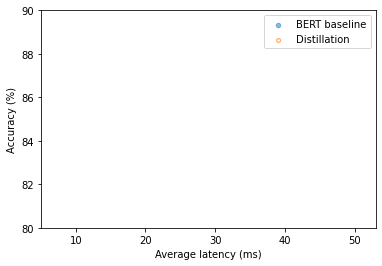

In [48]:
plot_metrics(perf_metrics, optim_type)

As expected, the model size and latency remain essentially unchanged compared to the `DistilBERT` benchmark, but the accuracy has improved and even surpassed the performance of the teacher! 

We can actually compress our distilled model even further using a technique
known as `quantization`.

##Quantization for Faster Models

###Quantizing Transformers in PyTorch

The main bottleneck for running inference with Transformers is the compute and memory
bandwidth associated with the enormous number of weights in these models. 

For this reason,
dynamic quantization is currently the best approach for Transformer-based models in NLP. 

In smaller computer vision models the limiting factor is the memory bandwidth of the activations
which is why static quantization is generally used and quantization aware training in cases
where the performance drops are too significant.

Implementing dynamic quantization in PyTorch is quite simple and can be done with a single line of code:

In [ ]:
model_ckpt = "models/distilbert-base-uncased-distilled-clinc"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt).to("cpu"))

model_quantized = quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)

###Benchmarking Quantized Model

Our model now quantized, let’s pass it through the benchmark and visualise the results:

In [ ]:
quantized_pipeline = TextClassificationPipeline(model=model_quantized, tokenizer=tokenizer)

optim_type = "Distillation + quantization"
pb = PerformanceBenchmark(quantized_pipeline, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

In [ ]:
plot_metrics(perf_metrics, optim_type)

Wow, the quantized model is almost half the size of our distilled one and twice as fast! 

Let’s see if we can push our optimization to the limit with a powerful framework called `ONNX` in the next notebook.

##Optimizing Inference with ONNX

ONNX is an open standard that defines a common set of operators and a common file format to represent deep learning models in a wide variety of frameworks, including PyTorch and TensorFlow. 

When a model is exported to the ONNX format, these operators are used to
construct a computational graph (often called an intermediate representation) which represents the flow of data through the neural network.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/images/6.png?raw=1' width='600'/>

By exposing a graph with standardized operators and data types, ONNX makes it easy to switch between frameworks. For example, a model trained in PyTorch can be exported to ONNX format and then imported in TensorFlow (and vice versa).

Where ONNX really shines is when it is coupled with a dedicated accelerator like the ONNX
Runtime, or ORT for short. ORT provides tools to optimize the ONNX graph through
techniques like operator fusion and constant folding, and defines an interface to Execution Providers that allow you to run the model on different types of hardware.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/images/7.png?raw=1' width='600'/>

To see ORT in action, the first thing we need to do is convert our distilled model into the ONNX format. 

Transformers has an in-built function called `convert_graph_to_onnx.convert` that simplifies the process by doing the following steps:

- Initializes the model as a Pipeline
- Runs dummy inputs through the pipeline so that ONNX can record the computational graph
- Defines dynamic axes to handle dynamic sequence lengths
- Saves the graph with network parameters

To use this function, we first need to set some OpenMP environment variables for ONNX:

In [52]:
%env OMP_NUM_THREADS={cpu_count()}   # sets the number of threads to use for parallel computations
%env OMP_WAIT_POLICY=ACTIVE          # specifies that waiting threads should be active

env: OMP_NUM_THREADS=2   # sets the number of threads to use for parallel computations
env: OMP_WAIT_POLICY=ACTIVE          # specifies that waiting threads should be active


Next, let’s convert our distilled model to the ONNX format. Here we need to specify the argument `pipeline_name="sentiment-analysis"` since convert wraps the model in a Transformers `pipeline` during the conversion. We use the `sentiment-analysis` argument since this is the name of the text classification pipeline in Transformers. 

In addition to the `model_ckpt` we also pass the tokenizer to initialize the pipeline:

In [ ]:
onnx_model_path = Path("onnx/model.onnx")
convert(framework="pt", model=model_ckpt, tokenizer=tokenizer, output=onnx_model_path, opset=12, pipeline_name="sentiment-analysis")

Now that we have our model saved, we need to create and inference session to feed inputs to the model:

In [54]:
def create_model_for_provider(model_path, provider="CPUExecutionProvider"):
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.graph_optimization_level = GraphOptimizationLevel.ORT_ENABLE_ALL

  session = InferenceSession(str(model_path), options, providers=[provider])
  session.disable_fallback()
  return session

In [55]:
onnx_model = create_model_for_provider(onnx_model_path)

Let’s test this out with an example from the test set. 

Since the output from the `convert` function tells us that ONNX expects just the `input_ids` and `attention_mask` as inputs, we need to drop the `label` column from our sample:

In [56]:
inputs = clinc_enc["test"][:1]
del inputs["labels"]

logits_onnx = onnx_model.run(None, inputs)[0]
logits_onnx.shape

(1, 151)

As expected, by specifying the `sentiment-analysis` pipeline name we get the class logits as the output so we can easily get the predicted label by taking the argmax:

In [57]:
np.argmax(logits_onnx)

61

which indeed agrees with the ground truth label:

In [58]:
clinc_enc["test"][0]["labels"]

61

Since we cannot use the `TextClassificationPipeline` class to wrap our ONNX
model, we’ll create our own class that mimics the core behaviour.

In [61]:
class OnnxPipeline:
  def __init__(self, model, tokenizer):
    self.model = model
    self.tokenizer = tokenizer

  def __call__(self, query):
    model_inputs = self.tokenizer(query, return_tensors="pt")
    inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}
    logits = self.model.run(None, inputs_onnx)[0][0, :]
    probs = softmax(logits)
    pred_idx = np.argmax(probs).item()
    return [{"label": intents.int2str(pred_idx), "score": probs[pred_idx]}]

We can then test this on our simple query to see if we recover the `car_rental` intent:

In [62]:
onnx_pipeline = OnnxPipeline(onnx_model, tokenizer)
onnx_pipeline(query)

[{'label': 'car_rental', 'score': 0.8851938}]

Great, our pipeline works well so the next step is to create a performance benchmark for ONNX models.

Here we can build on the work we did with the `PerformanceBenchmark`
class by simply overriding the `compute_size` function and leaving the
`compute_accuracy` and `time_pipeline` functions intact. 

The reason we need to
override the `compute_size` function is that we cannot rely on the `state_dict` and `torch.save` to measure a model’s size since `onnx_model` is technically an ONNX InferenceSession object which doesn’t have access to the attributes of PyTorch’s `nn.Module`.

In [65]:
class OnnxPerformanceBenchmark(PerformanceBenchmark):
  def __init__(self, *args, model_path, **kwargs):
    super().__init__(*args, **kwargs)
    self.model_path = model_path

  def compute_size(self):
    size_mb = Path(self.model_path).stat().st_size / (1024 * 1024)
    print(f"Model size (MB) - {size_mb: .2f}")
    return {"size_mb": size_mb}

With our new benchmark, let’s see how our distilled model performs when converted to ONNX format:

In [66]:
optim_type = "Distillation + ORT"
pb = OnnxPerformanceBenchmark(onnx_pipeline, clinc["test"], optim_type=optim_type, model_path="onnx/model.onnx")
perf_metrics.update(pb.run_benchmark())

Model size (MB) -  255.88
Average latency (ms) - 76.23 +\- 4.42
Accuracy on test set - 0.872


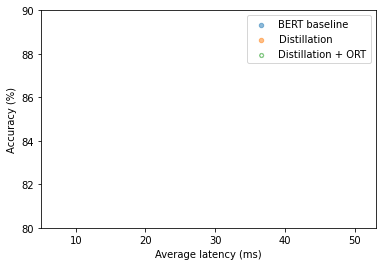

In [67]:
plot_metrics(perf_metrics, optim_type)

Remarkably, converting to the ONNX format and using the ONNX runtime has more than halved the average latency of our distilled model (and is almost five times faster than our baseline)! 

Let’s see if we can squeeze a bit more performance by applying some Transformerspecific optimizations.

###Optimizing for Transformer Architectures